In [7]:
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


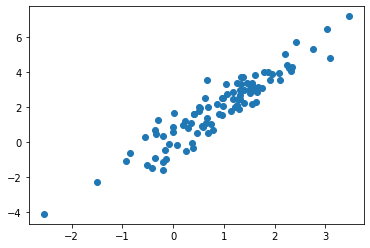

In [8]:
#  Generate Some “Real” Data
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())
plt.show()

In [9]:
batch_size = 8
data_iter = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

In [10]:
# Generator
net_G = nn.Sequential(nn.Linear(2, 2))

# Discriminator
net_D = nn.Sequential(
        nn.Linear(2, 5), nn.Tanh(),
        nn.Linear(5, 3), nn.Tanh(),
        nn.Linear(3, 1)
    )

In [12]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
                loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [23]:
lossD = []
lossG = []
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    for epoch in range(num_epochs):
       for X in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            lossD.append(update_D(X, Z, net_D, net_G, loss, trainer_D))
            lossG.append(update_G(Z, net_D, net_G, loss, trainer_G))
            # Visualize generated examples

lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
latent_dim, data[:100].detach().numpy())


In [22]:
plt.plot()

torch.Size([8, 2])
